In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

from skimage.color import rgb2lab, lab2rgb, rgb2gray
import matplotlib.pyplot as plt
import cv2  
import os
from PIL import Image
from Project_model import ColorizationResNet, ColorizationResNet2
from supplement_f import ColorizationDataset, compute_mse, compute_cross_entropy, conti_ab_2_class, class_2_ab

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
Learning_rate = 0.0001
Weight_decay = 0.9
RANDOM_SEED = 123
NUM_EPOCHS = 10
BATCH_SIZE = 3

## 1. A glance of data

In [4]:
image_gray = np.load('./image-colorization/l/gray_scale.npy')
image_lab1 = np.load('./image-colorization/ab/ab/ab1.npy')
image_lab2 = np.load('./image-colorization/ab/ab/ab2.npy')
image_lab3 = np.load('./image-colorization/ab/ab/ab3.npy')

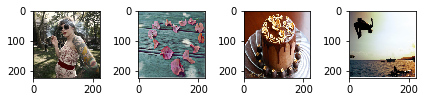

In [5]:
fig, ax = plt.subplots(1,4)
for i in range(4):
    images = np.concatenate((np.array([image_gray[i]]).transpose(1,2,0),image_lab1[i]),axis=2)
    images = cv2.cvtColor(images, cv2.COLOR_LAB2RGB)
    ax[i].imshow(images)

plt.tight_layout()

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
    ]),
}


train_dataset = ColorizationDataset(os.path.join('image-colorization', 'total'), 
                                transform=data_transforms['train'])

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

valid_dataset = ColorizationDataset(os.path.join('image-colorization', 'valid'), 
                                transform=data_transforms['valid'])

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

test_dataset = ColorizationDataset(os.path.join('image-colorization', 'test'), 
                               transform=data_transforms['valid'])

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

## 2. Initilizeing Model

In [7]:
model = ColorizationResNet2().to(DEVICE)
torch.manual_seed(RANDOM_SEED)

optimizer = torch.optim.Adam(model.parameters(), lr = Learning_rate)
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

## 2.1 Trainning Model

In [15]:
start_time = time.time()
minibatch_cost = []
epoch_cost, valid_cost = [], []
NUM_EPOCHS=50
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (input_gray, input_ab, targets) in enumerate(train_loader):
        
        input_gray = input_gray.to(DEVICE)
        output_ab_logsoftmax,_ = model.forward(input_gray)
        
        
        input_ab = conti_ab_2_class(input_ab)
        input_ab = torch.from_numpy(input_ab).long().to(DEVICE)
        
        
        cost = criterion(output_ab_logsoftmax, input_ab)
        
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        minibatch_cost.append(cost)
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f  | Time elapsed: %.2f min' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost, (time.time() - start_time)/60))

    if not epoch % 5:
        model.eval()
        with torch.set_grad_enabled(False):
            cost_train = compute_cross_entropy(model, train_loader, device=DEVICE)
            epoch_cost.append(cost_train)
            cost_valid = compute_cross_entropy(model, valid_loader, device=DEVICE)
            valid_cost.append(cost_valid)
            print('Epoch: %03d/%03d Train Cost: %.4f | Valid Cost: %.4f | Time elapsed: %.2f min' % (
                    epoch+1, NUM_EPOCHS, cost_train, cost_valid, (time.time() - start_time)/60))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 000/6666 | Cost: 6.5106  | Time elapsed: 0.02 min
Epoch: 001/050 | Batch 1000/6666 | Cost: 3.0233  | Time elapsed: 4.52 min
Epoch: 001/050 | Batch 2000/6666 | Cost: 2.6782  | Time elapsed: 8.97 min
Epoch: 001/050 | Batch 3000/6666 | Cost: 1.7223  | Time elapsed: 13.41 min
Epoch: 001/050 | Batch 4000/6666 | Cost: 2.6819  | Time elapsed: 17.73 min
Epoch: 001/050 | Batch 5000/6666 | Cost: 3.1070  | Time elapsed: 22.00 min
Epoch: 001/050 | Batch 6000/6666 | Cost: 2.3825  | Time elapsed: 26.27 min
Epoch: 001/050 Train Cost: 2.9863 | Valid Cost: 3.2616 | Time elapsed: 45.21 min
Time elapsed: 45.21 min
Epoch: 002/050 | Batch 000/6666 | Cost: 2.4481  | Time elapsed: 45.21 min
Epoch: 002/050 | Batch 1000/6666 | Cost: 3.6003  | Time elapsed: 49.46 min
Epoch: 002/050 | Batch 2000/6666 | Cost: 3.6689  | Time elapsed: 53.72 min
Epoch: 002/050 | Batch 3000/6666 | Cost: 2.1068  | Time elapsed: 57.98 min
Epoch: 002/050 | Batch 4000/6666 | Cost: 2.3276  | Time elapsed: 62.24 min


### 2.2 Saving and reloading model

In [16]:
checkpoint = {'epoch': epoch+1,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'pretrained/Multiclassification.pth')

In [8]:
state = torch.load('pretrained/Multiclassification.pth')

In [9]:
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

### 2.3 Cheaking Loss

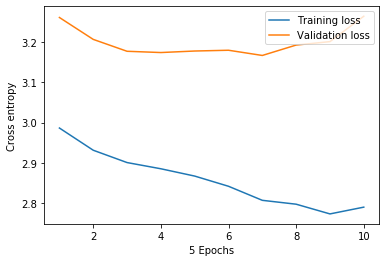

In [20]:
#plt.plot(range(1, len(minibatch_cost)+1), minibatch_cost, label='Minibatch loss')
plt.plot(range(1, len(epoch_cost)+1), epoch_cost, label='Training loss')
plt.plot(range(1, len(valid_cost)+1), valid_cost, label='Validation loss')

plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('5 Epochs')
plt.show()

### 3. Final Output

In [10]:
img_num_start=0
img_num=2
batch=5

In [11]:
model.eval()
for batch_idx, (input_gray, input_ab, targets) in enumerate(valid_loader):
    with torch.set_grad_enabled(False):

        input_gray = input_gray.to(DEVICE)
        input_ab = input_ab.to(DEVICE)
        targets = targets.to(DEVICE)

        _, output_ab = model.forward(input_gray)
    if batch_idx == batch:
        break

In [13]:
input_gray = input_gray.to('cpu').numpy()*255
input_gray = np.expand_dims(input_gray[:,0,:,:], axis=1)
input_gray = input_gray.astype('uint8')
input_ab = input_ab.to('cpu').numpy()+128
input_ab = input_ab.astype('uint8')
output_ab = output_ab.to('cpu').numpy()
output_ab = output_ab

### 3.1 Original Input

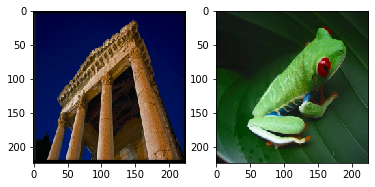

In [15]:
fig, ax = plt.subplots(1,img_num)
for i in range(img_num):
    images = np.concatenate((input_gray[img_num_start+i],input_ab[img_num_start+i]),
                            axis=0).transpose(1,2,0).astype('uint8')
    images = cv2.cvtColor(images, cv2.COLOR_LAB2RGB)
    ax[i].imshow(images)
    im = Image.fromarray(images)
    fname = str(i+image_lab1.shape[0])+'original'+'.png'
    #im.save(os.path.join('output_train',fname))
#plt.tight_layout()

### 3.2 Grayscale Input

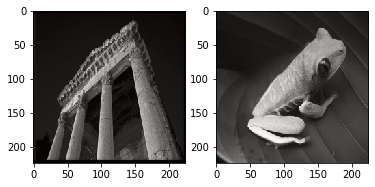

In [16]:
fig, ax = plt.subplots(1,img_num)
for i in range(img_num):
    images = np.concatenate((input_gray[img_num_start+i],np.zeros([2,224,224])+129),
                            axis=0).transpose(1,2,0).astype('uint8')
    images = cv2.cvtColor(images, cv2.COLOR_LAB2RGB)
    ax[i].imshow(images)
    im = Image.fromarray(images)
    fname = str(i+image_lab1.shape[0])+'gray'+'.png'
    #im.save(os.path.join('output_train',fname))
#plt.tight_layout()

### 3.3 Colorized Output

In [17]:
index = np.arange(625).reshape(-1,1,1)

In [18]:
W = 100

In [19]:
output_ab_colorized = class_2_ab(output_ab, 1000)

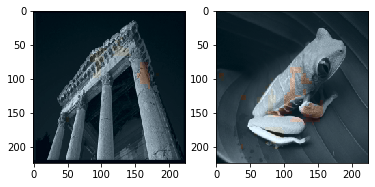

In [20]:
fig, ax = plt.subplots(1,img_num)
for i in range(img_num):
    images = np.concatenate((input_gray[img_num_start+i],output_ab_colorized[img_num_start+i]),
                            axis=0).transpose(1,2,0).astype('uint8')
    images = cv2.cvtColor(images, cv2.COLOR_LAB2RGB)
    ax[i].imshow(images)
    im = Image.fromarray(images)
    fname = str(i+image_lab1.shape[0])+'colorized'+'.png'
    #im.save(os.path.join('output_train',fname))
#plt.tight_layout()

### 3.4 Chekaing Quantization Influence

In [21]:
input_ab_conti = input_ab
input_ab_conti = input_ab/10
input_ab_conti = input_ab_conti.astype(int)
input_a = input_ab_conti[:,0,:,:]
input_b = input_ab_conti[:,1,:,:]
input_ab_class = input_a*25 + input_b

In [22]:
input_ab_conti = np.expand_dims(input_ab_class, axis=1)
input_a_conti = (input_ab_conti/25).astype(int)
input_b_conti = np.mod(input_ab_conti, 25)
input_ab_conti = np.concatenate(( input_a_conti, input_b_conti), axis=1).astype(int)*10

In [23]:
output_ab_ori = input_ab_conti

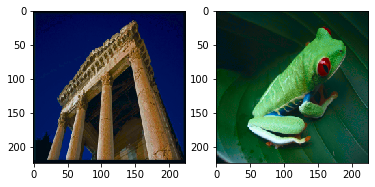

In [24]:
fig, ax = plt.subplots(1,img_num)
for i in range(img_num):
    images = np.concatenate((input_gray[img_num_start+i],output_ab_ori[img_num_start+i]),
                            axis=0).transpose(1,2,0).astype('uint8')
    images = cv2.cvtColor(images, cv2.COLOR_LAB2RGB)
    ax[i].imshow(images)
    im = Image.fromarray(images)
    fname = str(i+image_lab1.shape[0])+'colorized'+'.png'
    #im.save(os.path.join('output_train',fname))
#plt.tight_layout()